# Ibovespa prediction / Feature Selection

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(15)

## Loading Dataset

In [2]:
data = pd.read_csv('dataset.csv', index_col=0)
data.index = data.index.astype('datetime64[ns]')
date_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(date_index)

## Checking for empty values

In [3]:
(data.isnull().sum() > 0).sum()

0

There are no empty values in the dataset

## Setting input and target variables

In [4]:
target = '^BVSP'
X = data.drop(target, axis=1).values
y = data.loc[:,target].values

# Feature Selection

## Genetic Filter

In [5]:
import pygad
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
from sklearn.feature_selection import f_regression

def f(i, j):
    mi = mutual_info_regression(i.reshape(-1,1), j)[0]
    F, _ = f_regression(i.reshape(-1, 1), j)
    corr, _ = pearsonr(i, j)
  
    return mi + F[0] + abs(corr)

f_values = {}
ncols = X.shape[1]
for i in range(ncols - 1):
    for j in range(i + 1, ncols):
        f_value = f(X[:,i], X[:,j])
        f_values[(i, j)] = f_value
        f_values[(j, i)] = f_value
        
for i in range(ncols):
    f_value = f(y, X[:,i])
    f_values[('target', i)] = f_value

In [6]:
def fitness_func(solution, solution_idx):
    idx_selected = np.nonzero(solution)[0]
      
    f_features_target = 0
    for idx in idx_selected:
        f_features_target += f_values[('target', idx)]
        
    f_features = 0
    for i in range(len(idx_selected) - 1):
        for j in range(i + 1, len(idx_selected)):
            f_features += f_values[(idx_selected[i], idx_selected[j])]
          
    return f_features_target - f_features

ga = pygad.GA(
    num_parents_mating=4,
    keep_parents=3,
    sol_per_pop=100,
    num_generations=500,
    num_genes=ncols,
    crossover_type='two_points',
    mutation_type='random',
    mutation_probability=0.001,
    parent_selection_type='rws',
    gene_space=(0, 1),
    fitness_func=fitness_func,
    parallel_processing=['thread', 15]
)

ga.run()

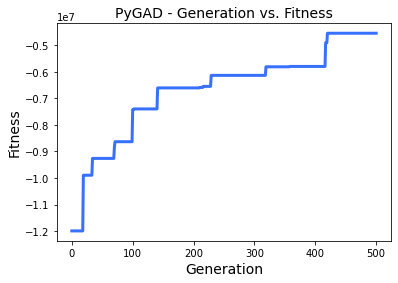

In [9]:
ga.plot_fitness()
plt.show()

In [20]:
filter_selected = np.nonzero(ga.best_solution()[0])[0]
filter_selected_ = np.array(data.columns[filter_selected])

In [22]:
filter_selected_

array(['AA', 'ABEV', 'AEO', 'AMD', 'APA', 'BA', 'BCS', 'BP', 'BSX', 'CCL',
       'CLF', 'COP', 'CS', 'EPD', 'FCX', 'HAL', 'HBAN', 'HL', 'HPQ',
       'IYH', 'JNJ', 'JWN', 'KGC', 'KO', 'LUMN', 'LUV', 'MS', 'NEM',
       'NLY', 'NVAX', 'NVDA', 'PBR', 'PFE', 'PLUG', 'SCHW', 'SLB', 'SO',
       'SWN', 'T', 'TELL', 'TEVA', 'TJX', 'VZ', 'WBA', 'X', 'XOM',
       '^AORD', '^JKSE', '^TA125.TA'], dtype=object)